In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),  # Random rotation within ±10 degrees
    transforms.RandomAffine(0, shear=5, scale=(0.8, 1.2)),  # Random affine transformation with scaling and shearing
    transforms.RandomPerspective(distortion_scale=0.1, p=0.1, interpolation=3),  # Random perspective for distortion
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random resized crop for scale variance
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast to simulate different ink effects
    transforms.RandomHorizontalFlip(),  # Flip the image horizontally (useful for letters like 'p' and 'q')
    transforms.RandomVerticalFlip(),    # Flip vertically (for certain cases like 'd' and 'p')
    transforms.ToTensor(),              # Convert image to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1] range
])

transform_test = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -u './drive/MyDrive/Train_Splitted_v2.zip'

Streaming output truncated to the last 5000 lines.
  inflating: content/drive/MyDrive/DeepLearning-Project/Train_Splitted/train/Praewa/Dataset-864.jpg  
  inflating: content/drive/MyDrive/DeepLearning-Project/Train_Splitted/train/Praewa/Dataset-358.jpg  
  inflating: content/drive/MyDrive/DeepLearning-Project/Train_Splitted/train/Praewa/Dataset-711.jpg  
  inflating: content/drive/MyDrive/DeepLearning-Project/Train_Splitted/train/Praewa/Dataset-755.jpg  
  inflating: content/drive/MyDrive/DeepLearning-Project/Train_Splitted/train/Praewa/Dataset-837.jpg  
  inflating: content/drive/MyDrive/DeepLearning-Project/Train_Splitted/train/Praewa/Dataset-388.jpg  
  inflating: content/drive/MyDrive/DeepLearning-Project/Train_Splitted/train/Praewa/Dataset-153.jpg  
  inflating: content/drive/MyDrive/DeepLearning-Project/Train_Splitted/train/Praewa/Dataset-591.jpg  
  inflating: content/drive/MyDrive/DeepLearning-Project/Train_Splitted/train/Praewa/Dataset-937.jpg  
  inflating: content/drive/MyDr

In [ ]:
ds_train = torchvision.datasets.ImageFolder(root=f'./content/drive/MyDrive/DeepLearning-Project/Train_Splitted/train', transform=transform)
ds_test = torchvision.datasets.ImageFolder(root=f'./content/drive/MyDrive/DeepLearning-Project/Train_Splitted/test', transform=transform_test)
# train_split = 0.8
# train_size = int(train_split * len(ds))
# test_size = len(ds) - train_size

# training_set, validation_set = torch.utils.data.random_split(ds, [train_size, test_size])

training_loader = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
print(ds_train.classes)
print(ds_train.class_to_idx)
idx_to_class = {v: k for k, v in ds_train.class_to_idx.items()}
idx_to_class

['Oak', 'Pat', 'Pookkie', 'Praewa', 'Tup']
{'Oak': 0, 'Pat': 1, 'Pookkie': 2, 'Praewa': 3, 'Tup': 4}


{0: 'Oak', 1: 'Pat', 2: 'Pookkie', 3: 'Praewa', 4: 'Tup'}

In [ ]:
# training_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
# validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=False)

print('Training set has {} instances'.format(len(ds_train)))
print('Validation set has {} instances'.format(len(ds_test)))

Training set has 4518 instances
Validation set has 1130 instances


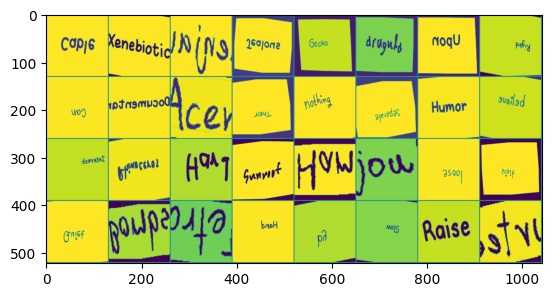

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [ ]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [ ]:
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time
#---Variable initialization---
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#-----------------------------

In [ ]:
model = torchvision.models.mobilenet_v3_large(weights='IMAGENET1K_V1').to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 37.2MB/s]


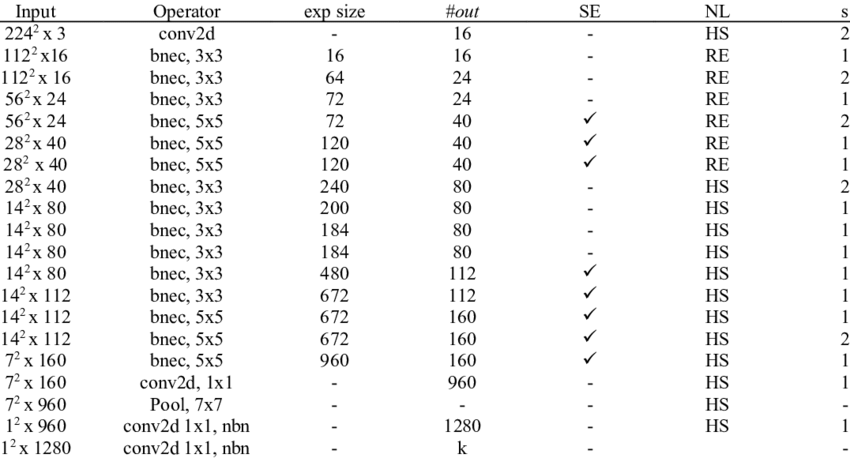

In [ ]:
model.classifier[3] = nn.Linear(in_features=1280, out_features=5, bias=True).to(device)

In [ ]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

In [ ]:
# Training parameters
lr = 1e-3
epochs = 7
#----------
epoch_number = 0
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

In [ ]:
loss_fn = loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [ ]:
t_0_accelerated = time.time()
for epoch in range(epochs):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'mbv3-large-pretrained-imagenet1k-finetuned-handwriting.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")

Epochs 1   train loss 0.14794 train acc 0.95086 validate loss 0.13425 validate acc 0.94867
--------------------------------------------------------------------------------


KeyboardInterrupt: 

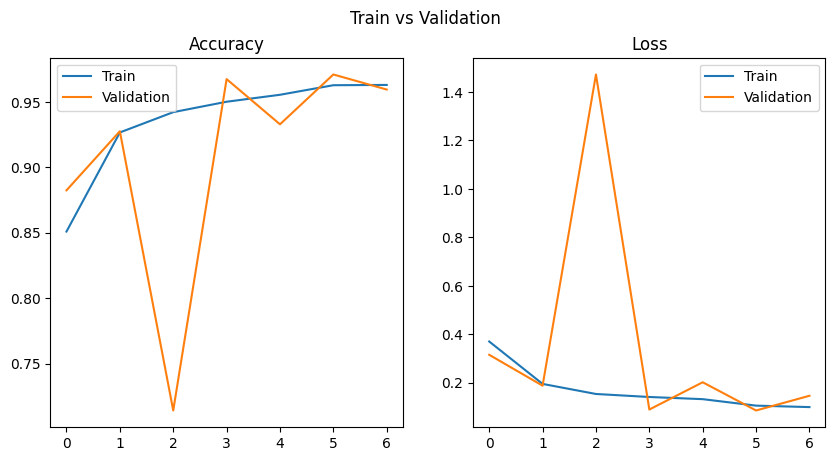

In [ ]:
plot_graph(training_logs)

In [ ]:
# Inference phase
#mbv3-large-imagenet1k-finetuned-handwriting
PATH = './cp/mbv3-large-pretrained-imagenet1k-finetuned-handwriting.pth'
# loaded_model = customhandwrittenmodel().to(device)
loaded_model = torchvision.models.mobilenet_v3_large(weights='IMAGENET1K_V1').to(device)
loaded_model.classifier[3] = nn.Linear(in_features=1280, out_features=5, bias=True).to(device)
loaded_model.load_state_dict(torch.load(PATH))
loss_fn = loss_fn = torch.nn.CrossEntropyLoss()
acc_test = 0
test_loss = 0
loaded_model.to(device).eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32).to(device)
for i, tdata in enumerate(validation_loader):
  with torch.no_grad():
    tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
    toutputs = loaded_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss
    # Argmax one-hot pred to class vector
    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()
    # store vec
    stored_lbs = torch.cat((stored_lbs, tlabels), 0).to(device)
    stored_preds = torch.cat((stored_preds, preds_t), 0).to(device)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(pretraining || test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

<ipython-input-47-da7864419f7c>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(PATH))


[(pretraining || test loss: 0.6615872979164124] [accuracy_test: 75.7 %]


In [ ]:
def predict(image, model):
    image = image.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        print(outputs)
        prob = torch.nn.functional.softmax(outputs, dim=1)
        top_prob, top_class = torch.max(prob, 1)
        prob = prob.cpu()
        probs = [t.numpy() for t in prob]
        print(prob)
        print(f"Predicted Class: {idx_to_class[top_class.item()]}")
        for p,i in zip(probs[0],ds_test.classes):
          print(f"class {i} :","{:.10f}".format(p))


In [ ]:
import random
num = random.randint(0,len(validation_loader.dataset))
image,label = validation_loader.dataset[num]
label


2

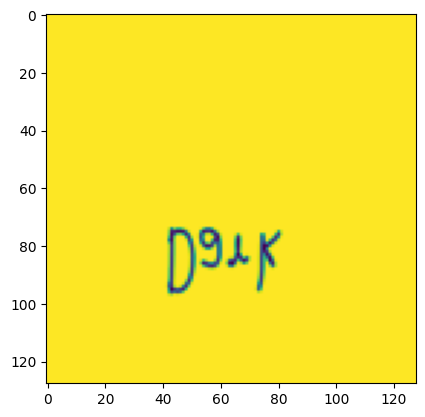

In [ ]:
matplotlib_imshow(image, one_channel=True)

In [ ]:
predict(image,loaded_model)

tensor([[-1.9526,  0.8956,  5.2262, -5.3240, -2.3185]], device='cuda:0')
tensor([[7.5169e-04, 1.2972e-02, 9.8573e-01, 2.5815e-05, 5.2136e-04]])
Predicted Class: Pookkie
class Oak : 0.0007516853
class Pat : 0.0129724285
class Pookkie : 0.9857286811
class Praewa : 0.0000258155
class Tup : 0.0005213643
